## Barycenter in NPC space

### import manifolds

In [198]:
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.spd_matrices import SPDMatrices
import matplotlib.pyplot as plt
import numpy as np
import math

### Hadamard space

In [177]:
def compute_squared_loss_hadamard(hadamard_mfd, point_list, x):
  loss = 0
  for n, point in enumerate(point_list):
    loss += hadamard_mfd.metric.squared_dist(point, x).item()
  return loss / (2)

### Implementation

In [363]:
def frechet_mean_hadamard(hadamard_mfd, point_list, num_iter, L, step_size=1, init_x = None, adaptive = True, A_order = 0, zeta = 1, ours = True):
  """
  Conduct GD for f(x) = -0.5*np.dot(X,np.dot(H, X))
  Reference: https://github.com/jungbinkim1/RNAG?tab=readme-ov-file
  """
  # create a list to save the result
  gd_f_list = []

  # initialize
  if init_x is None:
    gd_x_k = hadamard_mfd.random_point()
  else:
    gd_x_k = init_x

  # save the initial result
  current_gd_f = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_k)
  gd_f_list.append(current_gd_f)

  # create a step-size list
  stepsize_list = []

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  tilde_B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      if zeta is None:
        tilde_B[i] = (i+1)/2
        B[i] = 0.999 * (i+1)/2
      else:
        B[i] = (i+1)/2
        tilde_B[i] = B[i] + zeta
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      if zeta is None:
        B[i] = 0.999 * (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
      else:
        B[i] = (2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2))))
        tilde_B[i] = B[i] + zeta
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
      tilde_B[i] = 5/4 + 1
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      if zeta is None:
        tilde_B[i] = A[i] - 2
        # tilde_B[i] = 2 * np.power(i+a-2, A_order) - 2 + (5 / (1 + 2 * np.power(i+a-2, A_order)))
        B[i] = 0.999 * tilde_B[i]
      else:
        # B[i] = 2 * np.power(i+a-2, A_order) - 2 + (5 / (1 + 2 * np.power(i+a-2, A_order)))
        B[i] = A[i] - 2
        tilde_B[i] = B[i] + zeta
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    gd_grad = 0 * gd_x_k
    for point in point_list:
      gd_grad -= hadamard_mfd.metric.log(point, gd_x_k)
    # compute adaptive stepsize
    if adaptive:
      if ours:
        t= curr_iter
        s_prev = s_t1
        if t == 0:
          s_t1 = min(min(1/A[0], A[0]/tilde_B[1]) * s_prev, ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
          # s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (tilde_B[1]) ) * 1/L_e)
        elif t >= 1:
          t = t+1
          r_s = min((A[t-2]+1)/A[t-1], A[t-1]/tilde_B[t])
          if L_e > 0:
            if s_prev >= (1/L_e):
              r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * tilde_B[t] )
            else:
              r_l = A[t-1]/(tilde_B[t])
            s_t1 = min( r_s * s_prev, r_l * 1/L_e)
          else:
            s_t1 = r_s * s_prev

        # adaptive GD update
        stepsize_list.append(s_t1)
        f_old = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_k)
        gd_x_next = hadamard_mfd.metric.exp(-s_t1 * gd_grad, gd_x_k)
        f_new = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_next)

        # compute adaptive stepsize
        gd_grad_next = 0 * gd_x_next
        for point in point_list:
          gd_grad_next -= hadamard_mfd.metric.log(point, gd_x_next)
        gd_grad_next_on_old = hadamard_mfd.metric.parallel_transport(
          tangent_vec = gd_grad_next,  base_point =gd_x_next, end_point = gd_x_k
          )
        diff = gd_grad_next_on_old - gd_grad
        numerator = hadamard_mfd.metric.squared_norm(diff, gd_x_k)
        if numerator == 0:
          L_e = 0
        else:
          denominator = -2*(f_new - f_old + s_t1 * hadamard_mfd.metric.inner_product(gd_grad, gd_grad_next_on_old, gd_x_k))
          L_e = np.exp(np.log(numerator) - np.log(denominator))
          if L_e < 0 or (math.isnan(L_e)):
            L_e = 0
        # print(L_e)
      else:
        stepsize_list.append(s_t1)
        # gradient step
        gd_x_next = hadamard_mfd.metric.exp(-s_t1 * gd_grad, gd_x_k)

        # compute adaptive stepsize
        gd_grad_next = 0 * gd_x_next
        for point in point_list:
          gd_grad_next -= hadamard_mfd.metric.log(point, gd_x_next)

        # transport old → new, and measure differences at the NEW base point
        g_old_on_new = hadamard_mfd.metric.parallel_transport(
          tangent_vec = gd_grad,  base_point = gd_x_k, end_point = gd_x_next
          )

        # Riemannian norms (not squared) with correct base points
        norm_prev_sq = hadamard_mfd.metric.squared_norm(gd_grad, gd_x_k)
        if norm_prev_sq >= 0:
          norm_prev = math.sqrt(norm_prev_sq)
        else:
          norm_prev = 0
        diff = gd_grad_next - g_old_on_new
        norm_diff_sq = hadamard_mfd.metric.squared_norm(diff, gd_x_next)
        if norm_diff_sq >= 0:
          norm_diff = math.sqrt(norm_diff_sq)
        else:
          norm_diff = 0

        if (norm_diff == 0.0) or math.isnan(norm_diff):
            s_next = math.sqrt(1.0 + theta_t) * s_prev

        else:
            L_e_inv = (s_prev * norm_prev) / (math.sqrt(2.0) * norm_diff)
            s_next = min(math.sqrt(1.0 + theta_t) * s_prev, L_e_inv)

        theta_t = 0.0 if s_prev == 0.0 else (s_next / s_prev)

        s_prev = s_next
        s_t1   = s_next
      gd_x_k = gd_x_next
    else:
      stepsize_list.append(step_size)
      gd_x_k = hadamard_mfd.metric.exp(-step_size * gd_grad, gd_x_k)
    # save the result
    current_gd_f = compute_squared_loss_hadamard(hadamard_mfd, point_list, gd_x_k)
    gd_f_list.append(current_gd_f)

  # save the last result
  gd_x_last = gd_x_k

  # return the result
  return gd_f_list, gd_x_last, stepsize_list

### Simulations: Hyperbolic

In [364]:
np.random.seed(123)
d = 1000 #problem dimension
n = 10 #number of matrices to average
# hyperbolic_mfd = SPDMatrices(d)
hadamard_mfd = Hyperboloid(d)
mfd_point_list = []
for i in range(n):
  mfd_point_list.append(hadamard_mfd.random_point())

Experiments

In [365]:
L = 100
small_L = 0.5 * L
large_L = 2*L
num_iter = 1000
A_order_experi = 0.1
init_value = hadamard_mfd.random_point()
gd_f_list_j, gd_x_last_j, stepsize_gd = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/L,
                                                         init_x = init_value, adaptive=False)
print("GD Done")
gd_f_list_large, gd_x_last_large, stepsize_gd_large = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/large_L,
                                                         init_x = init_value, adaptive=False)
print("GD Done: large L")
gd_f_list_small, gd_x_last_small, stepsize_gd_small = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/small_L,
                                                         init_x = init_value, adaptive=False)
print("GD Done: small L")
adap_gd_f_list_a01, adap_gd_x_last_j_a01, stepsize_a01 = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                                       L = L, step_size=1e-03/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = 1)
print("AdaGDO(0.1) Done")
adap_gd_f_list_a01_none, adap_gd_x_last_j_a01_none, stepsize_a01_none = frechet_mean_hadamard(hadamard_mfd, 
                                                                                         mfd_point_list, num_iter,
                                                                       L = L, step_size=1e-03/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = None)
print("AdaGDO(0.1)_unknown_zeta Done")
adap_gd_f_list_am, adap_gd_x_last_j_am, stepsize_am = frechet_mean_hadamard(hadamard_mfd, 
                                                                                         mfd_point_list, num_iter,
                                                                       L = L, step_size=1e-03/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = None, ours = False)
print("[AM2025] Done")

GD Done
GD Done: large L
GD Done: small L


/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_53850/1949632617.py:111: RuntimeWarning: invalid value encountered in log
  L_e = np.exp(np.log(numerator) - np.log(denominator))


AdaGDO(0.1) Done
AdaGDO(0.1)_unknown_zeta Done
[AM2025] Done


Stepsize

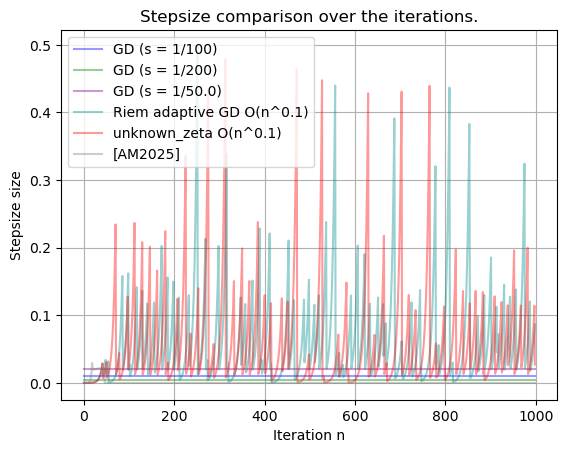

In [360]:
iterations = list(range((num_iter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "darkcyan", "red", "grey"]
labels = [f"GD (s = 1/{L})", f"GD (s = 1/{large_L})", f"GD (s = 1/{small_L})",
          f"Riem adaptive GD O(n^{A_order_experi})", "unknown_zeta O(n^0.1)", "[AM2025]"] # Labels for the legend

plt.plot(iterations, stepsize_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_large, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_small, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01_none, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_am, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

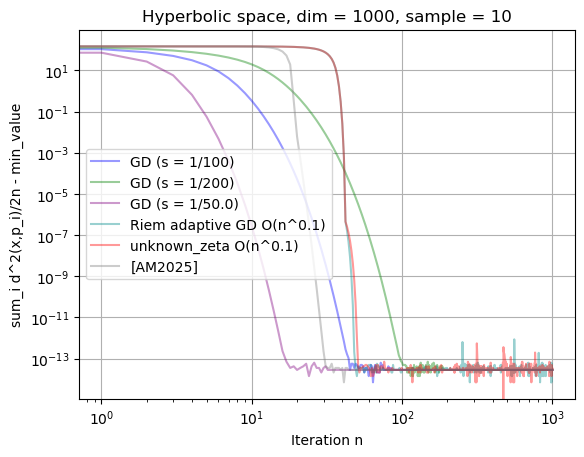

In [361]:
iterations = list(range((num_iter)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "darkcyan", "red", "grey"]
labels = [f"GD (s = 1/{L})", f"GD (s = 1/{large_L})", f"GD (s = 1/{small_L})",
          f"Riem adaptive GD O(n^{A_order_experi})", "unknown_zeta O(n^0.1)", "[AM2025]"] # Labels for the legend

min_value_1 = np.min(adap_gd_f_list_a01)
min_value_2 = np.min(gd_f_list_j)
min_value_3 = np.min(adap_gd_f_list_a01_none)
min_value_4 = np.min(gd_f_list_large)
min_value_5 = np.min(gd_f_list_small)
min_value_6 = np.min(adap_gd_f_list_am)
min_value = min(min_value_1, min_value_2, min_value_3, min_value_4, min_value_5, min_value_6)

plt.plot(iterations, gd_f_list_j - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_large - min_value, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_small - min_value, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01 - min_value, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01_none - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_am - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# plt.plot(iterations, gd_f_list_j, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, gd_f_list_large, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, gd_f_list_small, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_f_list_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_f_list_a01_none, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("sum_i d^2(x,p_i)/2n - min_value")
plt.title(f"Hyperbolic space, dim = {d}, sample = {n}" )
plt.xscale('log',base=10)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Simulation: SPD

In [316]:
np.random.seed(123)
d = 100 #problem dimension
n = 100 #number of matrices to average
hadamard_mfd = SPDMatrices(d)
mfd_point_list = []
for i in range(n):
  mfd_point_list.append(hadamard_mfd.random_point())

Experiments

In [317]:
L = 2000
small_L = 0.5 * L
large_L = 2*L
num_iter = 100
A_order_experi = 0.1
init_value = hadamard_mfd.random_point()
gd_f_list_j, gd_x_last_j, stepsize_gd = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/L,
                                                         init_x = init_value, adaptive=False)
print("GD Done")
gd_f_list_large, gd_x_last_large, stepsize_gd_large = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/large_L,
                                                         init_x = init_value, adaptive=False)
print("GD Done: large L")
gd_f_list_small, gd_x_last_small, stepsize_gd_small = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                         L = L, step_size = 1/small_L,
                                                         init_x = init_value, adaptive=False)
print("GD Done: small L")
adap_gd_f_list_a01, adap_gd_x_last_j_a01, stepsize_a01 = frechet_mean_hadamard(hadamard_mfd, mfd_point_list, num_iter,
                                                                       L = L, step_size=1/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = 1)
print("AdaGDO(0.1) Done")
adap_gd_f_list_a01_none, adap_gd_x_last_j_a01_none, stepsize_a01_none = frechet_mean_hadamard(hadamard_mfd, 
                                                                                         mfd_point_list, num_iter,
                                                                       L = L, step_size=1/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = None)
print("AdaGDO(0.1)_unknown_zeta Done")
adap_gd_f_list_am, adap_gd_x_last_j_am, stepsize_am = frechet_mean_hadamard(hadamard_mfd, 
                                                                                         mfd_point_list, num_iter,
                                                                       L = L, step_size=1/L, init_x = init_value,
                                                                       adaptive = True, A_order = 0.1, zeta = None, ours = False)
print("[AM2025] Done")

KeyboardInterrupt: 

Stepsize

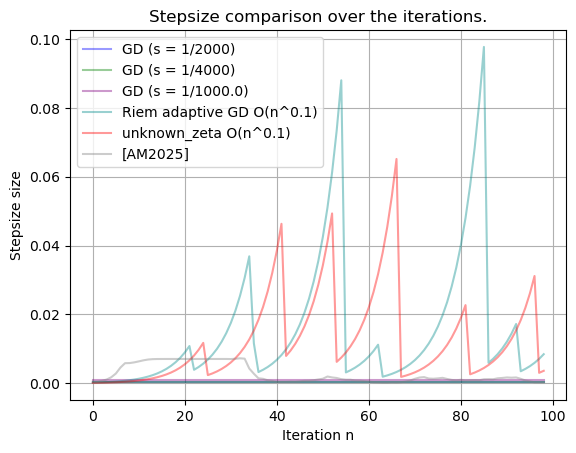

In [314]:
iterations = list(range((num_iter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "darkcyan", "red", "grey"]
labels = [f"GD (s = 1/{L})", f"GD (s = 1/{large_L})", f"GD (s = 1/{small_L})",
          f"Riem adaptive GD O(n^{A_order_experi})", "unknown_zeta O(n^0.1)", "[AM2025]"] # Labels for the legend

plt.plot(iterations, stepsize_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_large, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_gd_small, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01_none, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_am, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

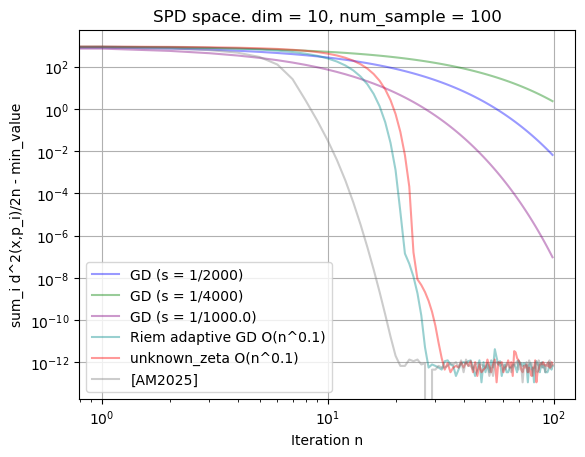

In [315]:
iterations = list(range((num_iter)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "darkcyan", "red", "grey"]
labels = [f"GD (s = 1/{L})", f"GD (s = 1/{large_L})", f"GD (s = 1/{small_L})",
          f"Riem adaptive GD O(n^{A_order_experi})", "unknown_zeta O(n^0.1)", "[AM2025]"] # Labels for the legend

min_value_1 = np.min(adap_gd_f_list_a01)
min_value_2 = np.min(gd_f_list_j)
min_value_3 = np.min(adap_gd_f_list_a01_none)
min_value_4 = np.min(gd_f_list_large)
min_value_5 = np.min(gd_f_list_small)
min_value_6 = np.min(adap_gd_f_list_am)
min_value = min(min_value_1, min_value_2, min_value_3, min_value_4, min_value_5, min_value_6)

plt.plot(iterations, gd_f_list_j - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_large - min_value, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
plt.plot(iterations, gd_f_list_small - min_value, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01 - min_value, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_a01_none - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_f_list_am - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# plt.plot(iterations, gd_f_list_j, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, gd_f_list_large, color=colors[1], label=labels[1], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, gd_f_list_small, color=colors[2], label=labels[2], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_f_list_a01, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_f_list_a01_none, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("sum_i d^2(x,p_i)/2n - min_value")
plt.title(f"SPD space. dim = {d}, num_sample = {n}" )
plt.xscale('log',base=10)
plt.yscale('log',base=10)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()